In [1]:
#位相シフタとPDを想定した複素エンコーダ(alpha=0.6)
#新decoderで復元

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [3]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data', 'MNIST_AE[5’]_1_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)

1209
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/MNIST_AE[5’]_1_result


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [5]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [6]:
#Encoder5
class Encoder(nn.Module):
    def __init__(self,DofIN,leverage,alpha=0.6):
        super(Encoder, self).__init__()
        real_part = nn.Parameter(torch.randn(int(DofIN/leverage), DofIN)*(1/np.sqrt(DofIN)))
        imag_part = nn.Parameter(torch.randn(int(DofIN/leverage), DofIN)*(1/np.sqrt(DofIN)))
        self.B = torch.complex(real_part, imag_part).detach()
        self.B.requires_grad = False

        self.alpha = alpha
    
    def forward(self, x):
        x = torch.exp(1j * self.alpha * x) #e^(iαx)
        x = x.T
        #print(x.shape)
        #print(self.B.shape)
        x = torch.matmul(self.B, x)
        x = torch.abs(x) ** 2
        x = x.T
        return x

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out

In [8]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [9]:
class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch):
        super(UNetDecoder, self).__init__()

        self.ch=ch
        self.fc = nn.Linear(num_in, ch*7*7)
        
        # ボトルネック部（7x7, ch=64）
        self.bottleneck = ResidualBlock(ch,ch,3)

        # 1回目のアップサンプルで14x14へ
        self.up1 = UpBlock(ch,ch)
        # スキップ接続用のResidualBlock（上げる前のx0をここで混ぜる）
        self.res1 = ResidualBlock(ch+ch,ch,3)

        # 2回目のアップサンプルで28x28へ
        self.up2 = UpBlock(ch,ch)
        # 同様にスキップ接続
        self.res2 = ResidualBlock(ch+ch,ch,3)

        # 最終的に1チャネルへ
        self.out_conv = nn.Conv2d(ch+ch, 1, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b = x.size(0)
        # 全結合で7x7, ch=64の特徴マップへ
        x = self.fc(x) #[B,ch*7*7]
        x = x.view(b, self.ch, 7, 7) #[B,ch,7,7]
        x0 = self.bottleneck(x)  # ボトルネック特徴,基礎的な特徴を整える

        # Up to 14x14
        x1 = self.up1(x0) #[B,ch,14,14]
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest')  # [B,ch,14,14]
        # スキップ接続: x0をconcat
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)

        # Up to 28x28
        x2 = self.up2(x1)
        # スキップ接続: x1をconcat
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')  # [B,C,28,28]
        x2 = torch.cat([x2, x1_up], dim=1)


        # 出力層
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out)  # [B,1,28,28],シグモイドで(0,1)に正規化
        x_out = x_out.view(b, -1)  # [B, 784]
        return x_out

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self,DofIN,leverage,ch):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(DofIN,leverage)  
        self.decoder = UNetDecoder(int(DofIN/leverage),ch)

    def forward(self, x):
        # 入力を[batch,1,28,28]としてエンコード
        x = x.view(x.size(0), -1) 
        latent = self.encoder(x) 
        # デコードして28x28画像再構成（最後は平坦化済み784次元で戻る）
        x_reconstructed = self.decoder(latent)
        return x_reconstructed

In [11]:
DofIN = 784 ##
num_N = 98 ##
ch = 32
leverage = 8


model = AutoEncoder(DofIN,leverage,ch)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
loss_train_ = []
loss_test_ = []

max_epochs = 10
for epoch in range(max_epochs):
    loss_train = 0
    loss_test = 0
    for (x,t) in train_dataloader:

        sys.stderr.write('\rEpoch: %d/%d' % (epoch, max_epochs)) 
        sys.stderr.flush()
        
        y = model(x)
        loss = criterion(y, x.view(x.size(0), -1)) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
       
    loss_train_avg = loss_train / len(train_dataloader)

    with torch.no_grad():
        for x, t in test_dataloader:
            y = model(x)
            loss = criterion(y, x.view(x.size(0), -1))
        
            loss_test += loss.item()

    loss_test_avg = loss_test / len(test_dataloader)

    loss_train_.append(loss_train_avg)
    loss_test_.append(loss_test_avg)
    



Epoch: 9/10

In [13]:
All_loss_train_avg = sum(loss_train_)/len(loss_train_)
All_loss_test_avg = sum(loss_test_)/len(loss_test_)

Last_loss_train = loss_train_[-1]
Last_loss_test = loss_test_[-1]

print('Train MSE AVG:  ',All_loss_train_avg)
print('Test MSE AVG:   ',All_loss_test_avg)

print('Train Last MSE: ',Last_loss_train)
print('Test Last MSE:  ',Last_loss_test)

Train MSE AVG:   0.01116351984255016
Test MSE AVG:    0.010376256985124201
Train Last MSE:  0.007779983276656519
Test Last MSE:   0.008450142377987503


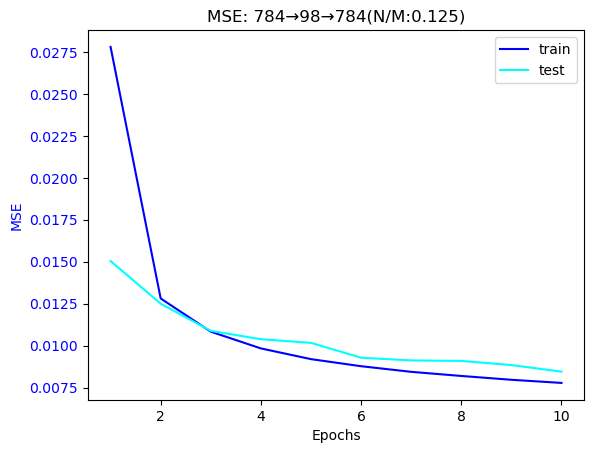

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
file_name = '%d_LOSS%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

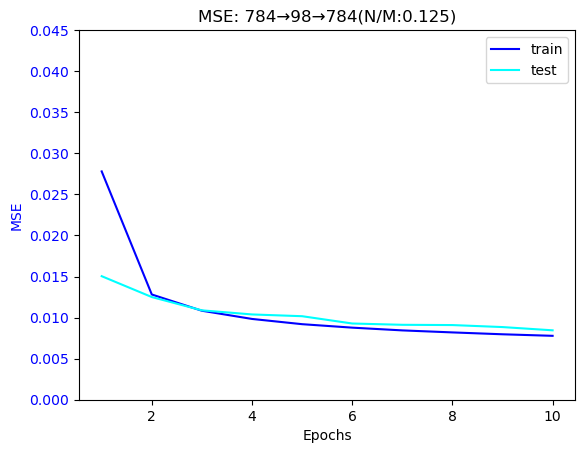

In [15]:
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.ylim(0,0.045)
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
file_name = '%d_LOSS%d→%d→%d_ex.png'%(int(formatted_date),DofIN,num_N,DofIN)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

In [16]:
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] 
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

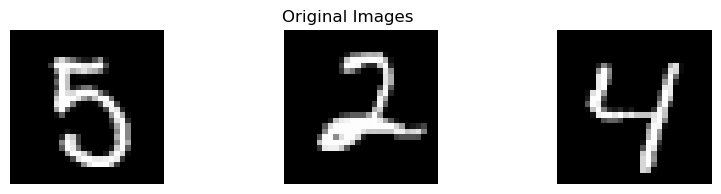

In [17]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:
        break
show_images(test_images, test_labels,"Original Images")

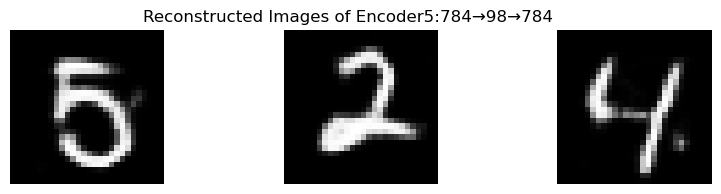

In [18]:
with torch.no_grad():
    reconstructed_images = model(test_images)
    show_images(reconstructed_images,test_labels, "Reconstructed Images of Encoder5:%d→%d→%d"%(DofIN,num_N,DofIN))
    file_name = '%d_ReImage%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

In [19]:
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[5_]_1_lis.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(loss_test_)

/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/texts
